In [28]:
import os
import json
from dotenv import load_dotenv
from supabase import create_client
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.checkpoint.memory import MemorySaver

In [29]:
load_dotenv()
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
SUPABASE_CONNECTION_STRING = os.getenv("SUPABASE_CONNECTION_STRING")

MODEL_SYSTEM_MESSAGE = """You are an AI assistant that helps users manage their home security system.
You can update the user's active monitoring events based on their requests.
You have access to a tool called update_active_events_tool that allows you to modify the active events list.
You can use this tool to add, remove, or modify events as per the user's instructions.
You have read-only knowledge of the user's cameras and their descriptions to understand event requests.
Camera descriptions (read-only, do not change):
{cameras}
Current active events (editable):
{active_events}
INSTRUCTIONS:
1. Identify any updates to the active events list:
    - Add new events explicitly mentioned by the user.
    - Remove events that the user explicitly requests to stop monitoring.
    - Modify existing events if the user provides new details.  
    """


In [31]:
supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
memory = PostgresSaver.from_conn_string(SUPABASE_CONNECTION_STRING)

@tool
def update_active_events_tool(active_events: list[str]) -> None:
    """
    Updates the active events  and list saves it to Supabase.
    """
    try:
        print(f"Updating active events: {active_events}")
        supabase.table("active_events").upsert({"user_id": "70c75ce4-a3af-4661-81d1-42e28ee2df9f", "events": active_events}).execute()
    except Exception as e:
        print(f"Error parsing JSON: {e}")
    
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools([update_active_events_tool])

In [32]:
class AgentState(MessagesState):
    active_events: list
    cameras: list

def chat_node(state: AgentState):
    system_message = SystemMessage(
        content=MODEL_SYSTEM_MESSAGE.format(
            cameras=json.dumps(state["cameras"], indent=2),
            active_events=json.dumps(state["active_events"], indent=2)
        )
    )
    messages = [system_message] + state["messages"]
    ai_reply = llm_with_tools.invoke(messages)
    if not isinstance(ai_reply, AIMessage):
        ai_reply = AIMessage(content=ai_reply.content)
    return {"messages": state["messages"] + [ai_reply]}

graph_builder = StateGraph(AgentState)
graph_builder.add_node("chat", chat_node)
graph_builder.add_node("tools", ToolNode(tools=[update_active_events_tool]))
graph_builder.add_edge(START, "chat")
graph_builder.add_conditional_edges("chat", tools_condition)
graph_builder.add_edge("tools", "chat")
memory = MemorySaver()
agent = graph_builder.compile(checkpointer=memory)


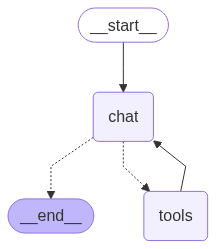

In [33]:
from IPython.display import display, Image
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [34]:
cameras = [
    {"id": "cam1", "description": "Front door camera"},
    {"id": "cam2", "description": "Backyard camera"},
    {"id": "cam3", "description": "Garage camera"},
]
active_events = ["Motion detected at front door","Garage door opened"]
config = {"configurable": {"thread_id": "1"}}
response =  agent.invoke({
    "messages": [HumanMessage(content ="Monitor the backyard for presence of a car.")],
    "active_events": active_events,
    "cameras": cameras
},config=config)

Updating active events: ['Motion detected at front door', 'Garage door opened', 'Car presence detected in backyard']


In [35]:
response_messages = response["messages"]
for message in response_messages:
    if isinstance(message, HumanMessage):
        print(f"User: {message.content}")
    elif isinstance(message, AIMessage):
        print(f"AI: {message.content}")
    elif isinstance(message, SystemMessage):
        print(f"System: {message.content}")

User: Monitor the backyard for presence of a car.
AI: I will add a new event to monitor the backyard for the presence of a car. Let's update the active events list.
AI: The active events list has been updated to monitor the backyard for the presence of a car. If you need any further adjustments, feel free to let me know!


In [36]:
# active_events = ["Motion detected at front door","Garage door opened"]
# supabase.table("active_events").upsert({"user_id": "70c75ce4-a3af-4661-81d1-42e28ee2df9f", "events": active_events}).execute()
supabase.table("active_events").select("events").eq("user_id", "70c75ce4-a3af-4661-81d1-42e28ee2df9f").execute()

APIResponse[TypeVar](data=[{'events': ['Motion detected at front door', 'Garage door opened', 'Car presence detected in backyard']}], count=None)